# Demand Time Series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

In [56]:
# загружаем данные
ts_retail = pd.read_csv('./train_kaggle.csv', sep=',')

ts_retail.head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,01.01.2015,NaN,22,163.78,NaN
1,1,1,02.01.2015,NaN,41,163.78,NaN
2,1,1,03.01.2015,NaN,35,163.78,NaN
3,1,1,04.01.2015,NaN,72,163.78,NaN
4,1,1,05.01.2015,NaN,25,163.78,NaN


In [57]:
ts_retail_test = pd.read_csv('./test_kaggle.csv', sep=',')

In [4]:
def process(data):
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
  data.set_index(['Date'], inplace=True)
  data['Promo'] = data['Promo'].fillna(0)
  data.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
  data['Regular_Price'] = data['Regular_Price'].ffill().bfill()
  data.reset_index().set_index(['Date'], inplace=True)

  # add actual price (promo price when promo occurred or regular price otherwise)
  data['Actual_Price'] = data['Promo_Price'].combine_first(data['Regular_Price'])
  data['Promo_percent'] = (1 - (data['Actual_Price'] / data['Regular_Price']))
  data = data.drop('Promo_Price', axis=1)

  data.reset_index(inplace=True)
  data["weekday"] = data['Date'].dt.weekday
  data["monthday"] = data['Date'].dt.day
  data['is_weekend'] = data['weekday'].isin([5, 6]) * 1
  data['month_period'] = 0
  data.loc[data['monthday'] >= 15, 'month_period'] = 1

  ## base feature

  data['demand_expanding_mean'] = data.groupby(['Store_id', 'SKU_id'])['Demand'].expanding().mean().droplevel(['Store_id', 'SKU_id'])
  data['demand_expanding_mean'] = data.groupby(['Store_id', 'SKU_id'])['demand_expanding_mean'].apply(lambda x: x.shift(14))


  return data

In [58]:
ts_retail = process(ts_retail)

In [59]:
ts_retail_test = process(ts_retail_test)

In [8]:
from ipywidgets import IntProgress

def percentile(n):
  """
  Calculate n - percentile of data
  """
  def percentile_(x):
      return np.nanpercentile(x, n)

  percentile_.__name__ = 'perc%s' % n
  return percentile_

## add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
  min_date, max_date = x[date_col].min(), x[date_col].max()
  groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
  results = groupby_day.sum(min_count=1)

  idx = pd.period_range(min_date, max_date)
  results = results.reindex(idx, fill_value=np.nan)

  results.index.rename(date_col, inplace=True)

  return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
  ## calc preaggregation
  data_preag = data.groupby(group_col).agg(
      preagg_method)[target_cols].reset_index()

  ## fill missing dates
  data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
      fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                  axis=1).reset_index()

  ## return DataFrame with calculated preaggregation and filled missing dates
  return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):
  ## calc rolling stats
  lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
      apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

  ## return DataFrame with rolled columns from target_vars
  return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
  ## calc ewm stats
  lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
      apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

  ## return DataFrame with rolled columns from target_vars
  return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):
  lf_df = lf_df_filled.groupby(
      level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
  lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

  ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
  return lf_df


def generate_lagged_features(
      data: pd.DataFrame,
      target_cols: list = ['Demand'],
      id_cols: list = ['SKU_id', 'Store_id'],
      date_col: str = 'Date',
      lags: list = [7, 14, 21, 28],
      windows: list = ['7D', '14D', '28D', '56D'],
      preagg_methods: list = ['mean'],
      agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
      dynamic_filters: list = ['weekday', 'Promo'],
      ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:

  ''' 
  data - dataframe with default index
  target_cols - column names for lags calculation
  id_cols - key columns to identify unique values
  date_col - column with datetime format values
  lags - lag values(days)
  windows - windows(days/weeks/months/etc.),
      calculation is performed within time range length of window
  preagg_methods - applied methods before rolling to make
      every value unique for given id_cols
  agg_methods - method of aggregation('mean', 'median', percentile, etc.)
  dynamic_filters - column names to use as filter
  ewm_params - span values(days) for each dynamic_filter
  '''

  data = data.sort_values(date_col)
  out_df = deepcopy(data)
  dates = [min(data[date_col]), max(data[date_col])]

  total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
  progress = IntProgress(min=0, max=total)
  display(progress)

  for filter_col in dynamic_filters:
    group_col = group_col = [filter_col] + id_cols + [date_col]
    for lag in lags:
      for preagg in preagg_methods:
        data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                            target_cols, preagg)

        ## add ewm features
        for alpha in ewm_params.get(filter_col, []):
          ewm_filled = calc_ewm(data_preag_filled, group_col,
                                date_col, alpha)
          ewm = shift(ewm_filled, group_col, date_col, lag)
          new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
              format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

          out_df = pd.merge(out_df,
                            ewm.rename(columns=new_names),
                            how='left',
                            on=group_col)

        for w in windows:
          for method in agg_methods:
              rolling_filled = calc_rolling(data_preag_filled,
                                            group_col, date_col,
                                            method, w)

              ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
              rolling = shift(rolling_filled, group_col, date_col,
                              lag)

              method_name = method.__name__ if type(
                  method) != str else method

              new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                            format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

              out_df = pd.merge(out_df,
                                rolling.rename(columns=new_names),
                                how='left',
                                on=group_col)
              progress.value += 1

  return out_df


In [60]:
target_cols = ['Demand']
id_cols = ['SKU_id']
date_col = 'Date'

In [61]:
data_lagged_features = generate_lagged_features(ts_retail 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [21, 28, 35, 42]
                    , windows = ['7D', '14D', '21D', '28D']
                    , preagg_methods = ['mean']
                    , agg_methods = ['mean', 'median', percentile(10),  percentile(90)]
                    , dynamic_filters = ['Promo', 'weekday']
                    , ewm_params={'Promo': [14, 42], 'weekday': [14, 28]}
                    )

IntProgress(value=0, max=128)

In [62]:
data_lagged_features_test = generate_lagged_features(ts_retail_test
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [21, 28, 35, 42]
                    , windows = ['7D', '14D', '21D', '28D']
                    , preagg_methods = ['mean']
                    , agg_methods = ['mean', 'median', percentile(10),  percentile(90)]
                    , dynamic_filters = ['Promo', 'weekday']
                    , ewm_params={'Promo': [14, 42], 'weekday': [14, 28]}
                    )

IntProgress(value=0, max=128)

In [80]:
# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

157


Index(['Date', 'Store_id', 'SKU_id', 'Promo', 'Demand', 'Regular_Price',
       'Actual_Price', 'Promo_percent', 'weekday', 'monthday',
       ...
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling'],
      dtype='object', length=157)

## ML Model Training

In [81]:
data_lagged_features_ml = data_lagged_features.set_index(['Date'])

In [82]:
data_lagged_features_ml

,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,weekday,monthday,is_weekend,...,Demand_lag42d_w14D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling,Demand_lag42d_w14D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling,Demand_lag42d_w21D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1,1,0.0,22,163.78,163.78,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,47,2,0.0,0,142.57,142.57,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,31,1,0.0,28,163.78,163.78,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,70,2,0.0,0,135.78,135.78,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,48,2,0.0,0,135.78,135.78,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-22,77,1,1.0,518,128.98,119.60,0.072724,6,22,1,...,138.893878,140.738776,145.781331,140.969388,139.12449,154.36295,162.931359,149.340364,139.355102,197.380412
2016-05-22,78,1,1.0,858,128.98,119.60,0.072724,6,22,1,...,138.893878,140.738776,145.781331,140.969388,139.12449,154.36295,162.931359,149.340364,139.355102,197.380412
2016-05-22,66,2,0.0,3,138.50,138.50,0.000000,6,22,1,...,3.406122,4.206122,3.929168,4.175258,3.47995,4.27995,16.882443,4.240690,3.566863,40.311424


In [83]:
# train specific model for each SKU
sku1_train = data_lagged_features_ml[data_lagged_features_ml['SKU_id'] == 1]
sku2_train = data_lagged_features_ml[data_lagged_features_ml['SKU_id'] == 2]

In [84]:
data_lagged_features_ml_test = data_lagged_features_test.set_index(['Date'])

In [85]:
# test specific model for each SKU
sku1_test = data_lagged_features_ml_test[data_lagged_features_ml_test['SKU_id'] == 1]
sku2_test = data_lagged_features_ml_test[data_lagged_features_ml_test['SKU_id'] == 2]

In [18]:
# try lightgbm as ml algorithm
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

def plot_feature_importance(model, X , num = 20): 
  # , fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    # sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

In [101]:
import xgboost as xg

xgb1 = xg.XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=5, subsample=0.4)
xgb1.fit(sku1_train.drop(['SKU_id','Demand'], axis=1), sku1_train.Demand)

xgb2 = xg.XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=5, subsample=0.4)
xgb2.fit(sku2_train.drop(['SKU_id','Demand'], axis=1), sku2_train.Demand)

XGBRegressor(max_depth=5, n_estimators=500, objective='reg:squarederror',
             subsample=0.4)

In [107]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.9 MB/s eta 0:00:00


In [122]:
# without CV
from catboost import CatBoostRegressor

catbst1 = CatBoostRegressor(learning_rate=0.1, max_depth=5, n_estimators=800, loss_function='MAE')
catbst1.fit(sku1_train.drop(['SKU_id','Demand'], axis=1), sku1_train.Demand)

catbst2 = CatBoostRegressor(learning_rate=0.1, max_depth=5, n_estimators=800, loss_function='MAE')

catbst2.fit(sku2_train.drop(['SKU_id','Demand'], axis=1), sku2_train.Demand)

0:	learn: 226.8235897	total: 128ms	remaining: 1m 42s
1:	learn: 215.0559231	total: 212ms	remaining: 1m 24s
2:	learn: 205.2509543	total: 291ms	remaining: 1m 17s
3:	learn: 196.7249363	total: 382ms	remaining: 1m 15s
4:	learn: 189.3636624	total: 481ms	remaining: 1m 16s
5:	learn: 182.8294926	total: 595ms	remaining: 1m 18s
6:	learn: 177.2724720	total: 693ms	remaining: 1m 18s
7:	learn: 172.8734993	total: 817ms	remaining: 1m 20s
8:	learn: 168.7089236	total: 946ms	remaining: 1m 23s
9:	learn: 165.3774272	total: 1.07s	remaining: 1m 24s
10:	learn: 162.3067746	total: 1.15s	remaining: 1m 22s
11:	learn: 159.6969941	total: 1.25s	remaining: 1m 22s
12:	learn: 157.5965016	total: 1.35s	remaining: 1m 21s
13:	learn: 155.4430885	total: 1.51s	remaining: 1m 24s
14:	learn: 153.5019356	total: 1.6s	remaining: 1m 24s
15:	learn: 152.1724538	total: 1.7s	remaining: 1m 23s
16:	learn: 150.6583667	total: 1.83s	remaining: 1m 24s
17:	learn: 149.3744081	total: 1.94s	remaining: 1m 24s
18:	learn: 147.9972671	total: 2.06s	rema

In [69]:
# without CV
lgbm1 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm1.fit(X = sku1_train.drop(['SKU_id','Demand'], axis=1), y = sku1_train.Demand)

lgbm2 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

lgbm2.fit(X = sku2_train.drop(['SKU_id','Demand'], axis=1), y = sku2_train.Demand)

LGBMRegressor(feature_fraction=0.7, metric='mae', n_estimators=500,
              num_leaves=40, subsample=0.4)

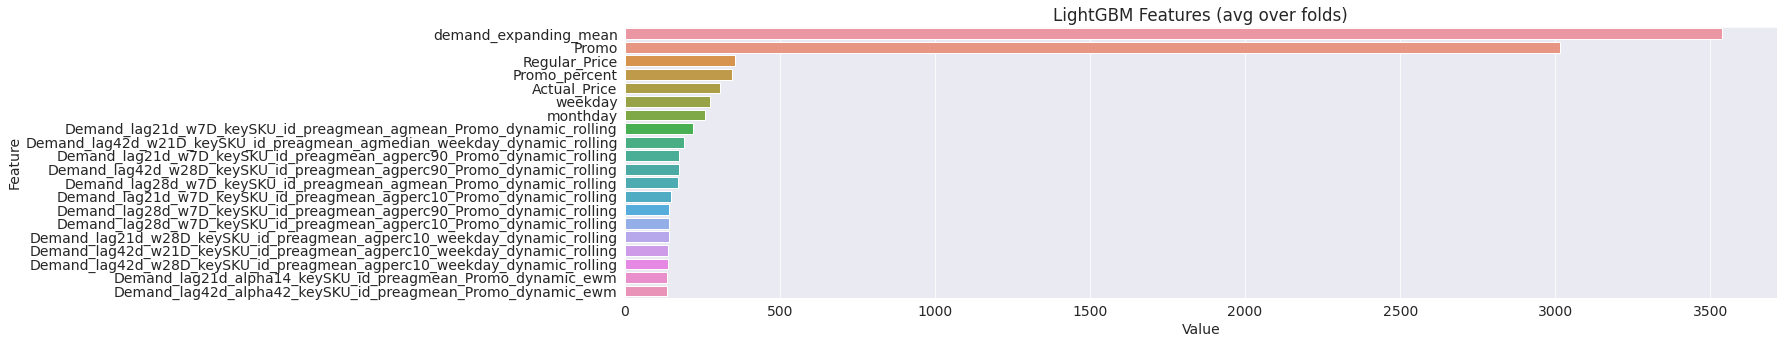

In [70]:
plot_feature_importance(lgbm1, sku1_train[sku1_train.columns[2:]], num = 20)

In [21]:
plot_feature_importance(xgb1, sku1_train[sku1_train.columns[2:]], num = 20)

NameError: ignored

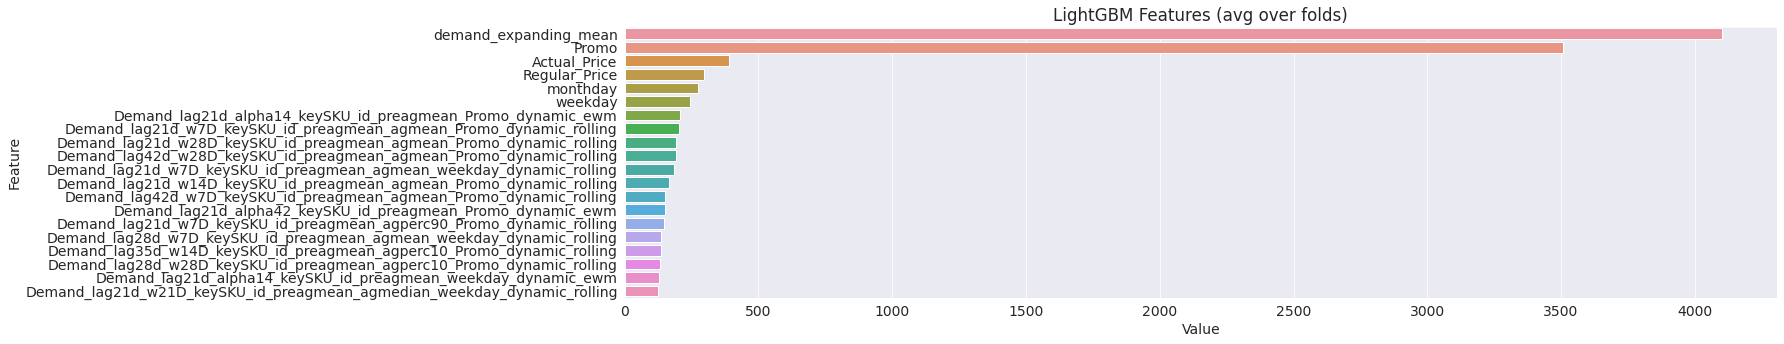

In [71]:
plot_feature_importance(lgbm2, sku2_train[sku2_train.columns[2:]], num = 20)

In [45]:
plot_feature_importance(xgb2, sku2_train[sku2_train.columns[2:]], num = 20)

NameError: ignored

### Cross-validation for time series
 **Caution**: ml parameters tuning steps are omitted! Only tech approach is shown.

In [23]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [110]:
# Train sets
X_train1 = sku1_train.drop(['SKU_id','Demand'], axis=1)
y_train1 = sku1_train.Demand
X_train2 = sku2_train.drop(['SKU_id', 'Demand'], axis=1)
y_train2 = sku2_train.Demand

In [25]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [73]:
# run TS CV for the sku 1 (if needed)
%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm2, wape, kwargs)

Size train set: (43733, 154)
Size of each fold: 2572

Splitting the first 2 chunks at 1/2
Size of train and test: (5144, 154)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 246.038
[4]	valid_0's l1: 231.539
[6]	valid_0's l1: 221.812
[8]	valid_0's l1: 212.972
[10]	valid_0's l1: 205.819
[12]	valid_0's l1: 202.586
[14]	valid_0's l1: 199.186
[16]	valid_0's l1: 198.343
[18]	valid_0's l1: 196.827
[20]	valid_0's l1: 194.248
[22]	valid_0's l1: 192.545
[24]	valid_0's l1: 191.751
[26]	valid_0's l1: 190.75
[28]	valid_0's l1: 189.562
[30]	valid_0's l1: 189.42
[32]	valid_0's l1: 189.155
[34]	valid_0's l1: 188.711
[36]	valid_0's l1: 188.83
[38]	valid_0's l1: 188.647
[40]	valid_0's l1: 188.913
[42]	valid_0's l1: 188.713
[44]	valid_0's l1: 188.82
Early stopping, best iteration is:
[35]	valid_0's l1: 188.599

Splitting the first 3 chunks at 2/3
Size of train and test: (7716, 154)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 418.222
[4]

46.845512143411284

In [74]:
# run TS CV for the sku 2 (if needed)
%%time
performTimeSeriesCV(X_train2, y_train2, 17, lgbm2, wape, kwargs)

Size train set: (43183, 154)
Size of each fold: 2540

Splitting the first 2 chunks at 1/2
Size of train and test: (5080, 154)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 3.36126
[4]	valid_0's l1: 3.23576
[6]	valid_0's l1: 3.12811
[8]	valid_0's l1: 3.05845
[10]	valid_0's l1: 3.01859
[12]	valid_0's l1: 2.9986
[14]	valid_0's l1: 2.9592
[16]	valid_0's l1: 2.93995
[18]	valid_0's l1: 2.91594
[20]	valid_0's l1: 2.9095
[22]	valid_0's l1: 2.88979
[24]	valid_0's l1: 2.86508
[26]	valid_0's l1: 2.85493
[28]	valid_0's l1: 2.85025
[30]	valid_0's l1: 2.83604
[32]	valid_0's l1: 2.82826
[34]	valid_0's l1: 2.8273
[36]	valid_0's l1: 2.81367
[38]	valid_0's l1: 2.80793
[40]	valid_0's l1: 2.81362
[42]	valid_0's l1: 2.81151
[44]	valid_0's l1: 2.80585
[46]	valid_0's l1: 2.80496
[48]	valid_0's l1: 2.81089
[50]	valid_0's l1: 2.8102
[52]	valid_0's l1: 2.80624
[54]	valid_0's l1: 2.81091
[56]	valid_0's l1: 2.81519
[58]	valid_0's l1: 2.8173
[60]	valid_0's l1: 2.81269
Early stoppi

95.46308296405823

In [123]:
# Test sets
X_test1 = sku1_test.drop(['SKU_id','Demand'], axis=1)
y_test1 = sku1_test.Demand
X_test2 = sku2_test.drop(['SKU_id', 'Demand'], axis=1)
y_test2 = sku2_test.Demand

## Forecast Generation with ML

In [111]:
X_train1.columns

Index(['Store_id', 'Promo', 'Regular_Price', 'Actual_Price', 'Promo_percent',
       'weekday', 'monthday', 'is_weekend', 'month_period',
       'demand_expanding_mean',
       ...
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling'],
  

In [113]:
X_test1.columns

Index(['id', 'Store_id', 'Promo', 'Regular_Price', 'Actual_Price',
       'Promo_percent', 'weekday', 'monthday', 'is_weekend', 'month_period',
       ...
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling'],
      dtype='object', length

In [ ]:
wape(X_test1['y_pred'], y_test1)

nan

In [94]:
X_train1.columns

Index(['Store_id', 'Promo', 'Regular_Price', 'Actual_Price', 'Promo_percent',
       'weekday', 'monthday', 'is_weekend', 'month_period',
       'demand_expanding_mean',
       ...
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling'],
  

In [92]:
X_test1.columns[1:]

Index(['Store_id', 'Promo', 'Regular_Price', 'Actual_Price', 'Promo_percent',
       'weekday', 'monthday', 'is_weekend', 'month_period',
       'demand_expanding_mean',
       ...
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc90_weekday_dynamic_rolling',
       'y_pred'],
      dtype='object', length=155)

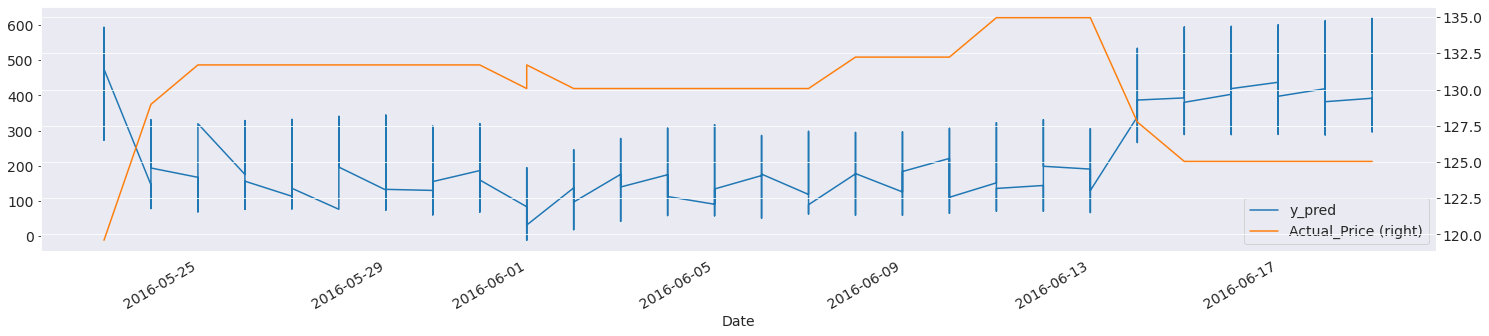

In [124]:
# forecast for sku 1
X_test1['y_pred'] = catbst1.predict(X_test1[X_test1.columns[1:]])
X_test1[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

In [34]:
X_test2.columns

Index(['id', 'Store_id', 'Promo', 'Regular_Price', 'Actual_Price',
       'Promo_percent', 'weekday', 'monthday', 'is_weekend', 'month_period',
       ...
       'Demand_lag42d_w14D_keySKU_id_preagstd_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagstd_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagstd_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagstd_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w21D_keySKU_id_preagstd_agperc90_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagstd_agmean_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagstd_agmedian_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagstd_agperc10_weekday_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagstd_agperc90_weekday_dynamic_rolling',
       'y_pred'],
      dtype='object', length=300)

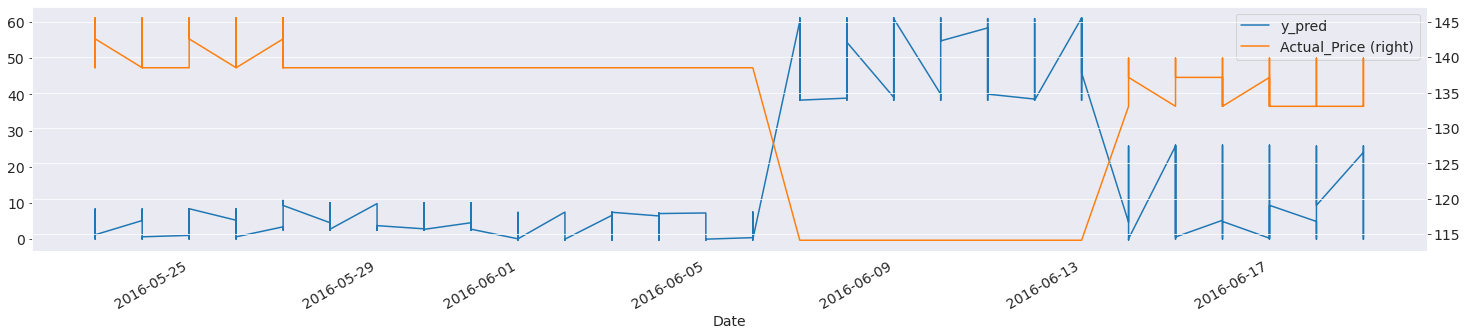

In [125]:
X_test2['y_pred'] = catbst2.predict(X_test2[X_test2.columns[1:]])
X_test2[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

In [126]:
result = pd.concat([X_test1.reset_index(), X_test2.reset_index()], sort=False, axis=0).reset_index().sort_values(by=['id'])

In [128]:
with open('csv_data.csv', 'w') as csv_file:
  result.to_csv(path_or_buf=csv_file, index=False, header=['id', 'Demand'], columns=['id', 'y_pred'])

In [127]:
result[['id', 'y_pred']]

,id,y_pred
0,0,487.150360
183,1,223.596222
307,2,220.310532
407,3,229.190140
504,4,232.417202
...,...,...
5439,5965,24.177350
5563,5966,24.177359
5660,5967,24.149101
5849,5968,23.920093
